In [1]:
using CSV, DataFrames, CategoricalArrays, Statistics, StatsPlots

# read from files created by R with baseline risk probas computed via cox models
train_data = CSV.read("traindata/unmatched_with_risk_preds_set2.csv", DataFrame) #1259x15 size (70% subset from cox model split in R Studio)
unique(train_data.:adjuvantchemo)
summary(train_data)
train_data

Row,age,size,cea_carcinoembryonic.antigen,number_liver_mets,DFI.12,T_stage,N_stage,rightleft.Rec,extrahepatic.disease,R0,KRAS,adjuvantchemo,died,time_to_event,size_binary,dying_prob_5y
,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64
1,61.0,0.4,6.3,1.0,0,2,0,2,0,1,1,0,1,1454.91,0,0.589568
2,58.0,4.0,1.4,4.0,0,3,0,0,1,0,1,1,0,1104.88,0,0.589568
3,48.0,4.0,153.0,1.0,0,3,0,2,1,1,1,1,1,535.7,0,0.589568
4,32.0,1.0,3.0,2.0,1,2,1,2,1,0,1,1,0,995.306,0,0.742908
5,65.0,3.0,43.1,2.0,0,3,0,1,1,0,1,1,0,508.306,0,0.589568
6,56.0,2.9,7.9,1.0,0,4,1,0,1,0,1,0,0,1031.83,0,0.742908
7,58.0,2.7,34.4,3.0,0,4,0,0,1,0,1,0,1,815.725,0,0.589568
8,75.0,4.0,93.7,1.0,0,2,0,0,1,0,1,0,1,368.294,0,0.589568
9,58.0,2.3,120.0,1.0,0,3,1,0,1,0,1,0,0,118.706,0,0.742908


**Prognostic buckets**

In [2]:
# Function to categorize risk probabilities into buckets
function categorize_risk_in_buckets(data,num_buckets)
    df = deepcopy(data)
    
    # Compute quantiles to determine bucket boundaries
    quantiles = [quantile(df[:, :dying_prob_5y], q) for q in LinRange(0, 1, num_buckets+1)]

    # Assign each patient to a bucket based on quantiles
    df[:, :risk_bucket] .= 0  # Initialize bucket labels

    for i in 1:num_buckets
        mask = (quantiles[i] .<= df[:, :dying_prob_5y]) .& (df[:, :dying_prob_5y] .<= quantiles[i+1])
        df[mask, :risk_bucket] .= i
    end
            # Display bin edge values
    println("Bin Edge Values risk:")
    for i in 1:length(quantiles)-1
        println("Bucket $i: $(round(quantiles[i],digits=2)) - $(round(quantiles[i+1],digits=2))")
    end
      return df
end
# Add a new column "RiskBucket" to the DataFrame
train_data = categorize_risk_in_buckets(train_data,10)
X_new = train_data[:,Not([:died,:time_to_event])]

y = train_data.died
t = train_data.time_to_event;


Bin Edge Values risk:
Bucket 1: 0.45 - 0.45
Bucket 2: 0.45 - 0.5
Bucket 3: 0.5 - 0.59
Bucket 4: 0.59 - 0.6
Bucket 5: 0.6 - 0.6
Bucket 6: 0.6 - 0.6
Bucket 7: 0.6 - 0.65
Bucket 8: 0.65 - 0.74
Bucket 9: 0.74 - 0.74
Bucket 10: 0.74 - 0.8


In [47]:
function categorize_risk_in_deciles(data, num_buckets)
    df = deepcopy(data)

    # Initialize bucket boundaries
    bucket_boundaries = collect(0:0.1:1)

    # Assign each patient to a bucket based on deciles
    df[:, :risk_bucket] .= 0  # Initialize bucket labels
    for i in 1:num_buckets
        mask = (bucket_boundaries[i] .<= df[:, :dying_prob_5y]) .& (df[:, :dying_prob_5y] .< bucket_boundaries[i+1])
        df[mask, :risk_bucket] .= i
    end

    # Display bin edge values
    println("Bin Edge Values risk:")
    for i in 1:length(bucket_boundaries)-1
        println("Bucket $i: $(bucket_boundaries[i]) - $(bucket_boundaries[i+1])")
    end

    return df
end

# Add a new column "RiskBucket" to the DataFrame
train_data2 = categorize_risk_in_deciles(train_data, 10);

Bin Edge Values risk:
Bucket 1: 0.0 - 0.1
Bucket 2: 0.1 - 0.2
Bucket 3: 0.2 - 0.3
Bucket 4: 0.3 - 0.4
Bucket 5: 0.4 - 0.5
Bucket 6: 0.5 - 0.6
Bucket 7: 0.6 - 0.7
Bucket 8: 0.7 - 0.8
Bucket 9: 0.8 - 0.9
Bucket 10: 0.9 - 1.0


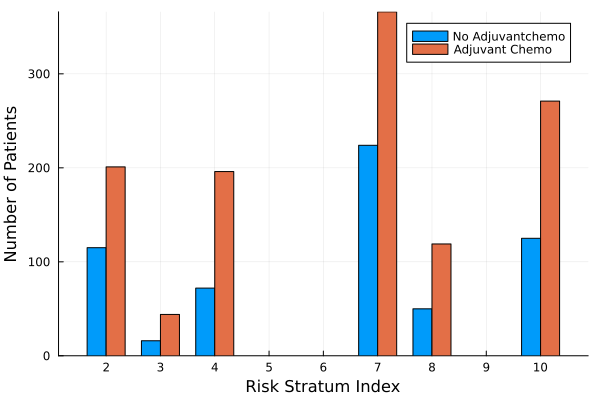

In [3]:
function plot_histogram(X, add_to_title)
    # Group by RiskBucket and RxRegimen, then count the number of patients
    grouped_df = combine(groupby(X, [:risk_bucket, :adjuvantchemo]), nrow => :Patients)
    # Filter DataFrame for "None" and other regimens
    df_none = filter(row -> row.adjuvantchemo == 0, grouped_df)
    df_treated = filter(row -> row.adjuvantchemo == 1, grouped_df)
    
    # Group by RiskBucket and sum the number of patients for each regimen
    grouped_none = combine(groupby(df_none, :risk_bucket), :Patients => sum => :NonePatients)
    grouped_treated = combine(groupby(df_treated, :risk_bucket), :Patients => sum => :TreatedPatients)
    # Merge DataFrames on RiskBucket
    merged_df = innerjoin(grouped_none, grouped_treated, on=:risk_bucket)
    # Create a grouped bar plot with two bars side by side for each risk bucket
    groupedbar(merged_df[!, :risk_bucket], hcat(merged_df[!, :NonePatients], merged_df[!, :TreatedPatients]),
        bar_position=:dodge, 
        bar_width=0.7, 
        label=["No Adjuvantchemo" "Adjuvant Chemo"],
        xlabel="Risk Stratum Index", ylabel="Number of Patients",
        #title= "Histogram"*add_to_title,
        legend=:topright, fmt=:png)
    xticks!(1:1:maximum(merged_df[!, :risk_bucket]))
        
    # Save the plot as a PNG file
    #savefig("plots_and_metrics/histogram_"*add_to_title*".png")
   
end
hist = plot_histogram(train_data, "train_before_decile")

In [4]:
# Group DataFrame by hemoglobin_bucket and RxRegimen, and count number of patients in each group
grouped_df = combine(groupby(X_new, [:risk_bucket, :adjuvantchemo]), nrow => :NumPatients)

# Find the bucket with the smallest number of patients for each RxRegimen
min_bucket_by_regimen = combine(groupby(grouped_df, :adjuvantchemo)) do subgroup
    min_row = argmin(subgroup[:, :NumPatients])
    return subgroup[min_row, :]
end

display(min_bucket_by_regimen)
global_min_bucket_size = minimum(min_bucket_by_regimen[:, :NumPatients])


Row,adjuvantchemo,risk_bucket,NumPatients
,Int64,Int64,Int64
1,0,3,16
2,1,3,44


16

In [5]:
function get_dfA_dfB(X1)
# store patient group with higher number of patients as dfB, lower number as dfA 
    if nrow(X1[X1."adjuvantchemo" .== 0,:]) <  nrow(X1[X1."adjuvantchemo" .!= 0,:])
        dfA = X1[X1."adjuvantchemo" .== 0,:] 
        dfB = X1[X1."adjuvantchemo" .!= 0,:] 
    else 
        dfA = X1[X1."adjuvantchemo" .!= 0,:]
        dfB = X1[X1."adjuvantchemo" .== 0,:] 
    end
    return dfA, dfB
end
# Create a matrix of the distance between 2 feature vectors of Group A and B
using LinearAlgebra,StatsBase
# standardize numerical columns
function standardize_for_distance_matrix(data)
    # Identify columns containing vectors of Float64
    float_cols = names(data, Float64)

    # Identify columns containing Int64 (binary data)
    int_cols = names(data, Int64)

    # Select columns with vectors of Float64
    X = select(data, float_cols)

    # Get standard deviations for each column
    std_devs = [std(X[:, col]) for col in 1:size(X, 2)]

    # Standardize columns with vectors of Float64, excluding columns where the standard deviation is 0
    for (i, std_dev) in enumerate(std_devs)
        if std_dev != 0
            # Standardize the column
            X[:, i] .= zscore(X[:, i])
        else
            println(" std is zero for column ", names(X)[i])
        end
    end
    
    # Combine standardized columns with columns containing Int64
    standardized_data = hcat(select(data, int_cols), X)
    
    # Get the order of columns after standardization
    column_order = vcat(int_cols, float_cols)
    return standardized_data, column_order
end


function get_distance_matrix(dfA, dfB, set_number)
    
    
    # Standardize the data and get the column order
    standardized_data_A, column_order_A = standardize_for_distance_matrix(dfA)
    standardized_data_B, column_order_B = standardize_for_distance_matrix(dfB)
     # Define the columns to be included
    if set_number == 1
        include_columns = Set(["CEA_binary_20","KRAS","N_stage", "TBS_binary","extrahepatic.disease"])
    elseif set_number == 2
        include_columns = Set(["size_binary", "N_stage", "KRAS"])
    else set_number == 3
        include_columns = Set(["size_binary", "N_stage", "CEA_binary_200","DFI.12","number_binary"])
    end
    # Convert the Set to an Array for indexing
    include_columns_array = collect(include_columns)

        # Extract the relevant columns and convert to a Matrix
    A_mat = Matrix(standardized_data_A[:, include_columns_array])
    B_mat = Matrix(standardized_data_B[:, include_columns_array])
    
    # Check for NaN values
    nan_indices = hcat(findall(isnan, A_mat), findall(isnan, B_mat))
    if length(nan_indices) > 0
        println("NaN values are present in the matrix.")
    end
    distances = [norm(A_row - B_row) for A_row in eachrow(A_mat), B_row in eachrow(B_mat)]
    print(size(distances))                
    return distances
end


get_distance_matrix (generic function with 1 method)

In [6]:
## june 5: no longer 1-to-1 but relax the matching 
## --> can discard untreated patients that have outlier characteristic
using Gurobi, JuMP, LinearAlgebra, SparseArrays
function matching_optimizer(m,n,d_matrix, ratio, global_min_bucket_size=0)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    @variable(model,z[1:m,1:n],Bin) 
    
    for i = 1:m
        @constraint(model, sum(z[i,:]) <= 2) ## june 5: 1 or 2 to try
    end
    @constraints(model, begin 
        [j = 1:n], sum(z[:,j]) <= 2 ## june 5: allow multiple matches
        end)
    @constraint(model, sum(z) >= ratio*global_min_bucket_size) ## june 5: to try tuning

    
    @objective(model,Min, sum(sum(d_matrix[i,j]*z[i,j] for i=1:m) for j=1:n))
    # Solve the optimization problem
    optimize!(model)
    
    # Retrieve the objective value
    objective = JuMP.objective_value(model)
    
    return objective, value.(z)
end

function matching_optimizer_1to1(m,n,d_matrix, global_min_bucket_size=0)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    @variable(model,z[1:m,1:n],Bin) 
    for i = 1:m
        @constraint(model, sum(z[i,:]) == 1 ) 
    end
            
    @constraints(model, begin 
        [j = 1:n], sum(z[:,j]) <= 1
        end)
    @objective(model,Min, sum(sum(d_matrix[i,j]*z[i,j] for i=1:m) for j=1:n))
    # Solve the optimization problem
    optimize!(model)
    
    # Retrieve the objective value
    objective = JuMP.objective_value(model)
    
    return objective, value.(z)
end

function optimize_risk_range(file,df, ratio, global_min_bucket_size,set_number, one_to_one=false)
    risk_buckets = unique(df.risk_bucket)
    # match within each risk bucket
    total_cost = 0
    for risk_bucket in risk_buckets
        println("Bucket number: ",risk_bucket)
        
        bucket_data = df[df.risk_bucket .== risk_bucket, :]
        dfA, dfB = get_dfA_dfB(bucket_data)

        distances = get_distance_matrix(dfA, dfB, set_number)
        m = size(dfA)[1]
        n = size(dfB)[1]
        if one_to_one
            cost, z = matching_optimizer_1to1(m,n,distances,global_min_bucket_size)
        else
            cost, z = matching_optimizer(m,n,distances,ratio, global_min_bucket_size)
        end
        
        println("Optimal cost: ", cost)
        total_cost += cost
        rows, cols, vals = findnz(sparse(z))
         # scan through each column 1:n to discard the B patients who have not been matched to any of the m A patients
        println("size of dfA: ", size(dfA), "    size of dfB: ", size(dfB), " UNIQUE: ", size(unique(rows)),size(unique(cols)))
        
        data = vcat(dfA[unique(rows),:],dfB[unique(cols),:])
        println("size of bucket dataframe = ", size(data))
        CSV.write(file, data, append=true)
        println("Bucket cost: ",cost)
        println("")
    end
    println("Cumulative cost: ", total_cost)
end


optimize_risk_range (generic function with 2 methods)

In [9]:
using Printf
file = "traindata/matched_train.csv"  # Sample file name
titlerow = names(train_data)
# Generate range of ratio values from 1.5 to 2.0 in increments of 0.1
ratio_range = 1.0:0.1:1.0
for ratio_number in ratio_range
    ratio_number = 1.0 #########    shortcut!!!!!!!!!
    println(ratio_number)
    # Create file name with suffix
    file_suffix = "_1_to_1" 
    #file_suffix = "_ratio1.0" #* @sprintf("%.1f", ratio_number)  # Format the ratio number with one decimal place
    one_to_one = file_suffix == "_1_to_1"
    set_number = 2


    new_file = replace(file, ".csv" => file_suffix * "set"*string(set_number)*".csv")
    CSV.write(new_file, DataFrame([]); header=titlerow)
    # Call function with new file name
    optimize_risk_range(new_file, train_data, ratio_number, global_min_bucket_size,set_number,one_to_one)
    println(" ")
end

1.0
Bucket number: 4
 std is zero for column dying_prob_5y
(72, 196)Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 0.0
size of dfA: (72, 17)    size of dfB: (196, 17) UNIQUE: (72,)(72,)
size of bucket dataframe = (144, 17)
Bucket cost: 0.0

Bucket number: 10
(125, 271)Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 0.0
size of dfA: (125, 17)    size of dfB: (271, 17) UNIQUE: (125,)(125,)
size of bucket dataframe = (250, 17)
Bucket cost: 0.0

Bucket number: 8
(50, 119)Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 0.0
size of dfA: (50, 17)    size of dfB: (119, 17) UNIQUE: (50,)(50,)
size of bucket dataframe = (100, 17)
Bucket cost: 0.0

Bucket number: 7
(224, 366)Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-12
Optimal cost: 0.0
size of dfA: (224, 17)    size of dfB: (366, 1

In [15]:
train_data_cleaned = CSV.read("traindata/matched_train_1_to_1set2.csv", DataFrame) #1259x15 size (70% subset from cox model split in R Studio)
train_data_cleaned = CSV.read("traindata/matched_train_ratio1.0set2.csv", DataFrame) #1259x15 size (70% subset from cox model split in R Studio)


Row,age,size,cea_carcinoembryonic.antigen,number_liver_mets,DFI.12,T_stage,N_stage,rightleft.Rec,extrahepatic.disease,R0,KRAS,adjuvantchemo,died,time_to_event,size_binary,dying_prob_5y,risk_bucket
,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,58.0,3.43075,9.0,1.0,1,3,0,1,0,0,1,0,0,3929.48,0,0.589568,4
2,74.0,3.4,35.7631,1.0,0,3,0,0,0,0,1,0,0,821.812,0,0.589568,4
3,61.0,3.42442,5.9,1.0,0,4,0,0,1,0,1,0,1,124.794,0,0.589568,4
4,76.0,1.0,6.0,7.0,0,4,0,2,0,0,1,0,1,1646.67,0,0.589568,4
5,77.0,3.43254,17.0,2.0,0,3,0,1,1,1,1,0,1,1351.42,0,0.589568,4
6,73.0,1.8,4.8,1.0,0,2,0,1,0,0,1,0,0,1031.83,0,0.589568,4
7,61.0,0.4,6.3,1.0,0,2,0,2,0,1,1,0,1,1454.91,0,0.589568,4
8,67.0,1.8,76.7,1.0,0,3,0,2,0,1,1,0,0,4011.66,0,0.589568,4
9,66.0,1.6,8.2,1.0,0,2,0,0,0,0,1,0,0,1798.86,0,0.589568,4


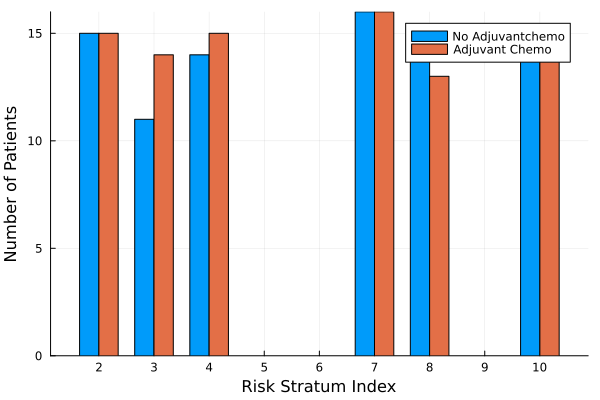

In [16]:
#plot_histogram(categorize_risk_in_deciles(train_data_cleaned,10), "train_before_decile")
plot_histogram(train_data_cleaned, "train_before_decile")